In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import pandas as pd

all_games_df = pd.read_csv("data/all_games.csv")
all_games_df.drop("Unnamed: 0", axis=1,inplace=True)

# Data Preparation

In [25]:
from api_helpers.game_stats_helpers import load_past_n_games
columns = ["FG_PCT", "FG3_PCT", "FTM", "OREB", "DREB", "REB", "AST"]
columns_a = [column + "_A" for column in columns]
columns_b = [column + "_B" for column in columns]

n_games_df = load_past_n_games(all_games_df=all_games_df, columns=columns)
n_games_df = n_games_df.dropna()

In [26]:
merged_data = pd.merge(
    all_games_df[columns_a + columns_b], n_games_df, left_index=True, right_index=True
)


columns_x = columns_a + columns_b
columns_x = [column + "_x" for column in columns_x]
X = merged_data[columns_x]

In [27]:
columns_y = columns_a + columns_b
columns_y = [column + "_y" for column in columns_y]
y = merged_data[columns_y]

## Test Train Split

In [28]:
from sklearn.model_selection import train_test_split
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# Preloading Neural Network

In [117]:
# Predicting Game Outcome
from tensorflow.keras.models import model_from_json

# load json and create model
json_file = open("tuned_nn.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("tuned.weights.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

Loaded model from disk


In [ ]:
y_final_true = all_games_df["WL_A"].loc[y_test.index].to_frame()
y_final_true.replace("W",1,inplace=True)
y_final_true.replace("L",0,inplace=True)
y_final_true.replace(" ",0,inplace=True)
y_final_true = list(y_final_true["WL_A"])

# Building and Testing XGBoost

In [126]:
best_model = model

In [8]:
%skip
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

UsageError: Line magic function `%skip` not found.


In [46]:
%skip
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

## Hyperparameter Tuning

In [148]:
from hyperopt import tpe, hp, STATUS_OK
from sklearn.metrics import r2_score, mean_squared_error
import hyperopt
import sklearn
import optuna


def objective(trial):
    # param = {
    #     "device": "cuda",
    #     "gamma": trial.suggest_categorical("gamma", [18, 19, 20, 21, 22, 23, 24, 25]),
    #     "learning_rate": trial.suggest_categorical(
    #         "learning_rate", [0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02]
    #     ),
    #     "colsample_bytree": trial.suggest_categorical(
    #         "colsample_bytree", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    #     ),
    #     "colsample_bynode": trial.suggest_categorical(
    #         "colsample_bynode", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    #     ),
    #     "n_estimators": trial.suggest_int("n_estimators", 30, 200),
    #     "max_depth": trial.suggest_categorical("max_depth", [3, 4, 5, 6, 7]),
    #     "subsample": trial.suggest_categorical("subsample", [0.5, 0.6, 0.7, 0.8, 1.0]),
    #     "random_state": 42,
    # }

    param = {
        "device": "cuda",
        "n_estimators": 100,
        "max_depth": 8,
        "eta": 0.1,
        "subsample": 0.4,
        "colsample_bytree": 0.9,
        "random_state": 42,
        "gamma": trial.suggest_categorical("gamma", [0, 1, 2, 3, 4, 5]),
        "learning_rate": trial.suggest_categorical(
            "learning_rate", [0.1, 0.2, 0.3, 0.4, 0.5]
        ),
        "colsample_bynode": trial.suggest_categorical(
            "colsample_bynode", [0.3, 0.4, 0.5, 0.6, 0.7]
        ),
    }

    model = XGBRegressor(**param)

    model.fit(X_train, y_train, verbose=False)

    y_pred = model.predict(X_test)

    scaler = joblib.load("scaler.bin")

    y_final_pred = loaded_model.predict(scaler.transform(y_pred))
    y_pred_true = np.argmax(y_final_pred, axis=1)

    y_pred_true = y_pred_true.tolist()

    accuracy = accuracy_score(y_final_true, list(y_pred_true))

    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=600)

[I 2024-07-21 16:30:11,001] A new study created in memory with name: no-name-64e4f5aa-3fdf-4837-95c6-7f8ed9b0ddf8


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


[I 2024-07-21 16:30:13,516] Trial 0 finished with value: 0.6678884137650173 and parameters: {'gamma': 1, 'learning_rate': 0.4, 'colsample_bynode': 0.5}. Best is trial 0 with value: 0.6678884137650173.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step


[I 2024-07-21 16:30:16,363] Trial 1 finished with value: 0.6136224801466097 and parameters: {'gamma': 3, 'learning_rate': 0.4, 'colsample_bynode': 0.7}. Best is trial 0 with value: 0.6678884137650173.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


[I 2024-07-21 16:30:18,337] Trial 2 finished with value: 0.6216656485440847 and parameters: {'gamma': 2, 'learning_rate': 0.2, 'colsample_bynode': 0.4}. Best is trial 0 with value: 0.6678884137650173.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


[I 2024-07-21 16:30:20,336] Trial 3 finished with value: 0.6365302382406842 and parameters: {'gamma': 2, 'learning_rate': 0.3, 'colsample_bynode': 0.3}. Best is trial 0 with value: 0.6678884137650173.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step


[I 2024-07-21 16:30:22,569] Trial 4 finished with value: 0.763490124210955 and parameters: {'gamma': 0, 'learning_rate': 0.2, 'colsample_bynode': 0.3}. Best is trial 4 with value: 0.763490124210955.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step


[I 2024-07-21 16:30:24,488] Trial 5 finished with value: 0.6165750356342904 and parameters: {'gamma': 3, 'learning_rate': 0.4, 'colsample_bynode': 0.3}. Best is trial 4 with value: 0.763490124210955.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step


[I 2024-07-21 16:30:26,063] Trial 6 finished with value: 0.590816534310731 and parameters: {'gamma': 5, 'learning_rate': 0.2, 'colsample_bynode': 0.7}. Best is trial 4 with value: 0.763490124210955.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


[I 2024-07-21 16:30:27,754] Trial 7 finished with value: 0.7641009977601303 and parameters: {'gamma': 0, 'learning_rate': 0.1, 'colsample_bynode': 0.3}. Best is trial 7 with value: 0.7641009977601303.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step


[I 2024-07-21 16:30:29,620] Trial 8 finished with value: 0.6181022195072287 and parameters: {'gamma': 3, 'learning_rate': 0.4, 'colsample_bynode': 0.4}. Best is trial 7 with value: 0.7641009977601303.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


[I 2024-07-21 16:30:32,151] Trial 9 finished with value: 0.6521075137446548 and parameters: {'gamma': 1, 'learning_rate': 0.1, 'colsample_bynode': 0.5}. Best is trial 7 with value: 0.7641009977601303.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step


[I 2024-07-21 16:30:35,223] Trial 10 finished with value: 0.7706169822846671 and parameters: {'gamma': 0, 'learning_rate': 0.1, 'colsample_bynode': 0.6}. Best is trial 10 with value: 0.7706169822846671.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step


[I 2024-07-21 16:30:40,920] Trial 11 finished with value: 0.7706169822846671 and parameters: {'gamma': 0, 'learning_rate': 0.1, 'colsample_bynode': 0.6}. Best is trial 10 with value: 0.7706169822846671.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


[I 2024-07-21 16:30:45,037] Trial 12 finished with value: 0.5849114233353696 and parameters: {'gamma': 4, 'learning_rate': 0.5, 'colsample_bynode': 0.6}. Best is trial 10 with value: 0.7706169822846671.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


[I 2024-07-21 16:30:48,085] Trial 13 finished with value: 0.7706169822846671 and parameters: {'gamma': 0, 'learning_rate': 0.1, 'colsample_bynode': 0.6}. Best is trial 10 with value: 0.7706169822846671.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


[I 2024-07-21 16:30:51,302] Trial 14 finished with value: 0.7706169822846671 and parameters: {'gamma': 0, 'learning_rate': 0.1, 'colsample_bynode': 0.6}. Best is trial 10 with value: 0.7706169822846671.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step


[I 2024-07-21 16:30:55,564] Trial 15 finished with value: 0.7706169822846671 and parameters: {'gamma': 0, 'learning_rate': 0.1, 'colsample_bynode': 0.6}. Best is trial 10 with value: 0.7706169822846671.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step


[I 2024-07-21 16:30:59,908] Trial 16 finished with value: 0.5856241091427408 and parameters: {'gamma': 4, 'learning_rate': 0.3, 'colsample_bynode': 0.6}. Best is trial 10 with value: 0.7706169822846671.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


[I 2024-07-21 16:31:01,746] Trial 17 finished with value: 0.5757483200977398 and parameters: {'gamma': 5, 'learning_rate': 0.5, 'colsample_bynode': 0.6}. Best is trial 10 with value: 0.7706169822846671.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step


[I 2024-07-21 16:31:04,484] Trial 18 finished with value: 0.7706169822846671 and parameters: {'gamma': 0, 'learning_rate': 0.1, 'colsample_bynode': 0.6}. Best is trial 10 with value: 0.7706169822846671.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


[I 2024-07-21 16:31:06,885] Trial 19 finished with value: 0.7706169822846671 and parameters: {'gamma': 0, 'learning_rate': 0.1, 'colsample_bynode': 0.6}. Best is trial 10 with value: 0.7706169822846671.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


[I 2024-07-21 16:31:09,572] Trial 20 finished with value: 0.7648136835675016 and parameters: {'gamma': 0, 'learning_rate': 0.1, 'colsample_bynode': 0.5}. Best is trial 10 with value: 0.7706169822846671.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step


[I 2024-07-21 16:31:12,607] Trial 21 finished with value: 0.7706169822846671 and parameters: {'gamma': 0, 'learning_rate': 0.1, 'colsample_bynode': 0.6}. Best is trial 10 with value: 0.7706169822846671.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


[I 2024-07-21 16:31:20,039] Trial 22 finished with value: 0.7706169822846671 and parameters: {'gamma': 0, 'learning_rate': 0.1, 'colsample_bynode': 0.6}. Best is trial 10 with value: 0.7706169822846671.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step


[I 2024-07-21 16:31:25,439] Trial 23 finished with value: 0.7706169822846671 and parameters: {'gamma': 0, 'learning_rate': 0.1, 'colsample_bynode': 0.6}. Best is trial 10 with value: 0.7706169822846671.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step


[I 2024-07-21 16:31:29,038] Trial 24 finished with value: 0.7706169822846671 and parameters: {'gamma': 0, 'learning_rate': 0.1, 'colsample_bynode': 0.6}. Best is trial 10 with value: 0.7706169822846671.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step


[I 2024-07-21 16:31:32,196] Trial 25 finished with value: 0.5873549175320708 and parameters: {'gamma': 4, 'learning_rate': 0.3, 'colsample_bynode': 0.4}. Best is trial 10 with value: 0.7706169822846671.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


[I 2024-07-21 16:31:35,025] Trial 26 finished with value: 0.5865404194665038 and parameters: {'gamma': 5, 'learning_rate': 0.5, 'colsample_bynode': 0.7}. Best is trial 10 with value: 0.7706169822846671.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step


[I 2024-07-21 16:31:38,176] Trial 27 finished with value: 0.6504785176135207 and parameters: {'gamma': 1, 'learning_rate': 0.1, 'colsample_bynode': 0.6}. Best is trial 10 with value: 0.7706169822846671.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


[I 2024-07-21 16:31:40,662] Trial 28 finished with value: 0.6170840969252698 and parameters: {'gamma': 2, 'learning_rate': 0.1, 'colsample_bynode': 0.6}. Best is trial 10 with value: 0.7706169822846671.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step


[I 2024-07-21 16:31:43,407] Trial 29 finished with value: 0.7648136835675016 and parameters: {'gamma': 0, 'learning_rate': 0.1, 'colsample_bynode': 0.5}. Best is trial 10 with value: 0.7706169822846671.


In [150]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  30
Best trial:
  Value: 0.7706169822846671
  Params: 
    gamma: 0
    learning_rate: 0.1
    colsample_bynode: 0.6


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
<class 'int'>
True
Best Neural Network classification report:
              precision    recall  f1-score   support

           0       0.97      0.43      0.60      3922
           1       0.72      0.99      0.84      5900

    accuracy                           0.77      9822
   macro avg       0.85      0.71      0.72      9822
weighted avg       0.82      0.77      0.74      9822



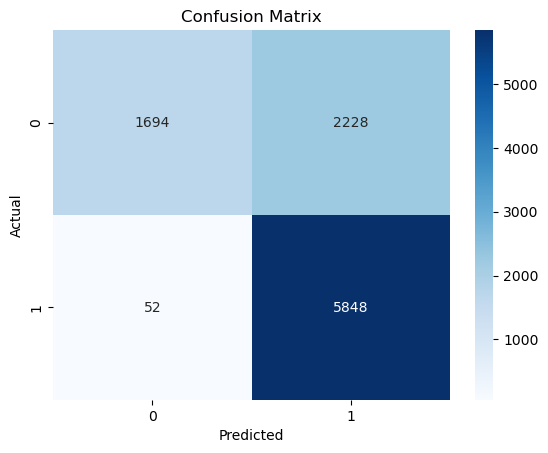

In [151]:

from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# create an xgboost regression model

best_params = trial.params

model = XGBRegressor(**best_params)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

scaler = joblib.load("scaler.bin")

y_final_pred = loaded_model.predict(scaler.transform(y_pred))
y_pred_true = np.argmax(y_final_pred, axis=1)

y_pred_true = y_pred_true.tolist()
print(type(y_pred_true[0]))

print(all(isinstance(x, int) for x in y_final_true))

# Evaluate the model
print('Best Neural Network classification report:')
print(classification_report(y_final_true, list(y_pred_true)))

# Confusion matrix
conf_matrix_nn = confusion_matrix(y_final_true, list(y_pred_true))
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
